In [27]:
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

# %env TF_KERAS=1
# import keras_self_attention

import jamo
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from unicode import join_jamos

sns.set(style='whitegrid')

In [28]:
MODEL_NUMBER = 211

DIM = 200
TEST_SIZE = 0.1

DATA_DIR = 'lol'
DATA_TYPE = 'full-nouns-trigram'
DATA_TEXT_TYPE = 'title-contents'

EMBED_TYPE = 'ft-pre'
DATA_EMBED_TYPE = '{}-{}{}'.format(DATA_TYPE, EMBED_TYPE, DIM)

if 'nouns' in DATA_TYPE:
    MAXLEN_TITLE = 16
    MAXLEN_LEDE = 24
    MAXLEN_CONTENTS = 128
else:
    MAXLEN_TITLE = 32
    MAXLEN_LEDE = 64
    MAXLEN_CONTENTS = 256

In [29]:
EMBEDDING_DIR = '4-embedding'
TRAINING_DATA_DIR = '5-training-data'
TRAINING_MODEL_DIR = '5-training-model'

embedding_dir = Path(EMBEDDING_DIR) / DATA_DIR
training_data_dir = Path(TRAINING_DATA_DIR) / DATA_DIR
training_model_dir = Path(TRAINING_MODEL_DIR) / DATA_DIR
training_checkpoint_dir = Path(training_model_dir) / 'regression-{}'.format(MODEL_NUMBER)

training_data_dir.mkdir(parents=True, exist_ok=True)
training_model_dir.mkdir(parents=True, exist_ok=True)
training_checkpoint_dir.mkdir(parents=True, exist_ok=True)

In [30]:
keras_model_path = training_model_dir / 'news-{}-{}-regression-{}'.format(DATA_EMBED_TYPE, DATA_TEXT_TYPE, MODEL_NUMBER)

### data

In [31]:
df = pd.read_csv(embedding_dir / 'news-{}.csv'.format(DATA_TYPE)).dropna()

train_range = df.date.apply(lambda x: 20150000 < x < 20200000)
test_range = df.date.apply(lambda x: 20200000 < x < 20210000)

def my_train_test_split(data):
    return data[train_range], data[test_range]

def my_train_val_test_split(data):
    train, test = my_train_test_split(data)
    train, val = train_test_split(train, test_size=0.1, random_state=119)
    return train, val, test

df_train, df_val, df_test = my_train_val_test_split(df)

In [32]:
# x_train_title, x_test_title = my_train_test_split(np.load(training_data_dir / 'news-{}-title.npy'.format(DATA_EMBED_TYPE)))
# x_train_contents, x_test_contents = my_train_test_split(np.load(training_data_dir / 'news-{}-contents.npy'.format(DATA_EMBED_TYPE)))
# # x_train_thumb, x_test_thumb = my_train_test_split(np.load(training_data_dir / 'news-thumbnail.npy'.format(DATA_TYPE))
# y_train, y_test = my_train_test_split(np.load(training_data_dir / 'news-view.npy'))
# y_train.shape, y_test.shape

x_train_title, x_val_title, x_test_title = my_train_val_test_split(np.load(training_data_dir / 'news-{}-title.npy'.format(DATA_EMBED_TYPE)))
x_train_contents, x_val_contents, x_test_contents = my_train_val_test_split(np.load(training_data_dir / 'news-{}-contents.npy'.format(DATA_EMBED_TYPE)))
# x_train_thumb, x_val_thumb, x_test_thumb = my_train_val_test_split(np.load(training_data_dir / 'news-thumbnail.npy'))
y_train, y_val, y_test = my_train_val_test_split(np.load(training_data_dir / 'news-view.npy'))
y_train.shape, y_val.shape, y_test.shape

((42417,), (4714,), (4155,))

In [33]:
x_train = [x_train_title, x_train_contents]
x_val = [x_val_title, x_val_contents]
x_test = [x_test_title, x_test_contents]

In [34]:
dates = df.date_input.apply(lambda x: datetime.strptime(x, '%Y%m%d %H:%M'))

MAX_YEAR = 2020
MIN_YEAR = 2015
years = dates.apply(lambda x: x.year-MIN_YEAR / (MAX_YEAR-MIN_YEAR)).to_numpy().reshape((len(df), 1))

months = dates.apply(lambda x: x.month / 12).to_numpy().reshape((len(df), 1))
days = dates.apply(lambda x: x.day / 31).to_numpy().reshape((len(df), 1))
times = dates.apply(lambda x: (x.hour * 60 + x.second) / 1440).to_numpy().reshape((len(df), 1))

le = LabelEncoder()
offices = tf.keras.utils.to_categorical(le.fit_transform(df.office))
offices = PCA(1, random_state=119).fit(my_train_val_test_split(offices)[0]).transform(offices)

x_train_meta, x_val_meta, x_test_meta = my_train_val_test_split(np.concatenate([months, times, offices], axis=1))
x_train = [x_train_title, x_train_contents, x_train_meta]
x_val = [x_val_title, x_val_contents, x_val_meta]
x_test = [x_test_title, x_test_contents, x_test_meta]

### train

In [35]:
LSTM_UNITS_TITLE = 32
LSTM_UNITS_CONTENTS = 128
DROPOUT = 0.4

TRAIN_BATCH_SIZE = 4096
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
EPOCHS = 512

VERBOSE = 2

In [36]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        values, query = inputs
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [37]:
def build_text_model(input_shape, lstm_units, suffix):
    layer_lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True, dropout=DROPOUT, name='lstm_{}'.format(suffix))
    layer_bilstm = tf.keras.layers.Bidirectional(layer_lstm, name='bilstm_{}'.format(suffix))
    layer_concat = tf.keras.layers.Concatenate(name='bilstm_hidden_state_{}'.format(suffix))
    layer_attention = BahdanauAttention(lstm_units, name='attention_{}'.format(suffix))
    # layer_attention = keras_self_attention.SeqWeightedAttention(return_attention=True, name='attention_{}'.format(suffix))
    
    inp = tf.keras.layers.Input(shape=input_shape, dtype='float32', name='input_{}'.format(suffix))
    bid, fwd_h, fwd_c, bwd_h, bwd_c = layer_bilstm(inp)
    bid_h = layer_concat([fwd_h, bwd_h])
    out, att_w = layer_attention([bid, bid_h])
    # out, att_w = layer_attention(bid)
    # att_w.set_shape((None, input_shape[0]))
    model = tf.keras.models.Model(inputs=inp, outputs=out, name='model_{}'.format(suffix))
    return model

def build_meta_model(input_shape, suffix):
    inp = tf.keras.layers.Input(shape=input_shape, dtype='float32', name='input_{}'.format(suffix))
    model = tf.keras.models.Model(inputs=inp, outputs=inp, name='model_{}'.format(suffix))
    return model

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_title (InputLayer)                         [(None, 16, 200)]                0                                                                   
______________________________________________________________________________________________________________________________________________________
input_contents (InputLayer)                      [(None, 128, 200)]               0                                                                   
______________________________________________________________________________________________________________________________________________________
bilstm_title (Bidirectional)                     [(None, 16, 64), (None, 32), (

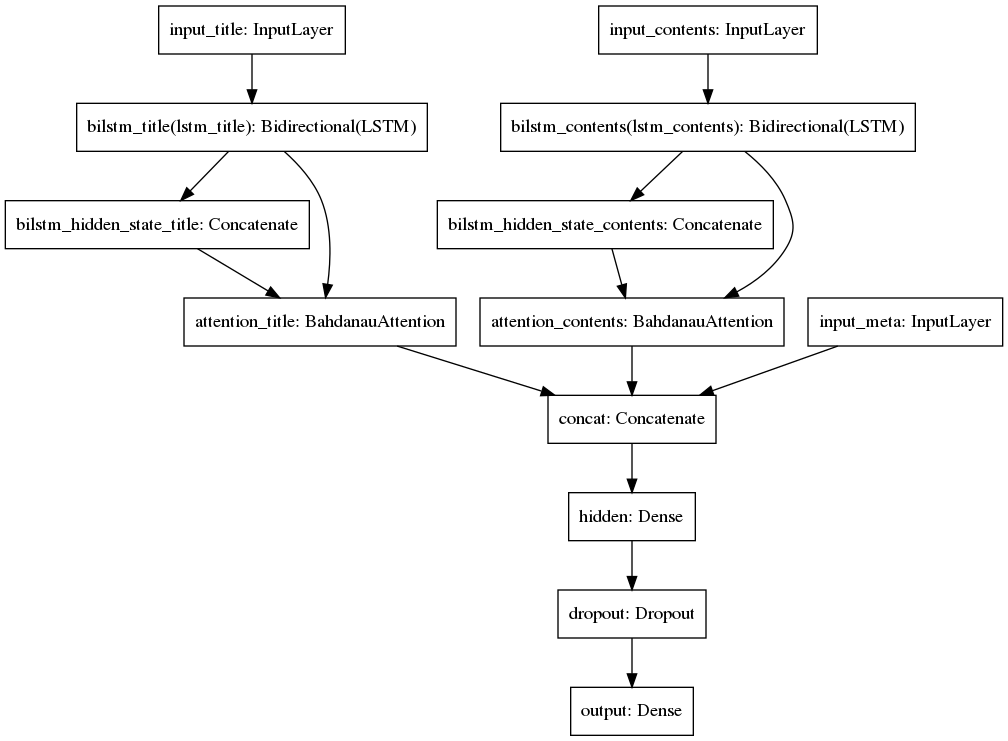

In [38]:
model_title = build_text_model(x_train_title.shape[1:], LSTM_UNITS_TITLE, suffix='title')
model_contents = build_text_model(x_train_contents.shape[1:], LSTM_UNITS_CONTENTS, suffix='contents')
model_meta = build_meta_model(x_train_meta.shape[1:], suffix='meta')

x = tf.keras.layers.Concatenate(name='concat')([model_title.output, model_contents.output, model_meta.output])
x = tf.keras.layers.Dense(x.shape[1], activation=tfa.activations.mish, name='hidden')(x)
x = tf.keras.layers.Dropout(DROPOUT, name='dropout')(x)
# x = tf.keras.layers.Dense(x.shape[1], activation=tfa.activations.mish, name='hidden_2')(x)
# x = tf.keras.layers.Dropout(DROPOUT, name='dropout_2')(x)
out = tf.keras.layers.Dense(1, name='output')(x)

model = tf.keras.models.Model(inputs=[model_title.input, model_contents.input, model_meta.input], outputs=out, name='model')
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae', 'mse'])
model.summary(line_length=150)
tf.keras.utils.plot_model(model)

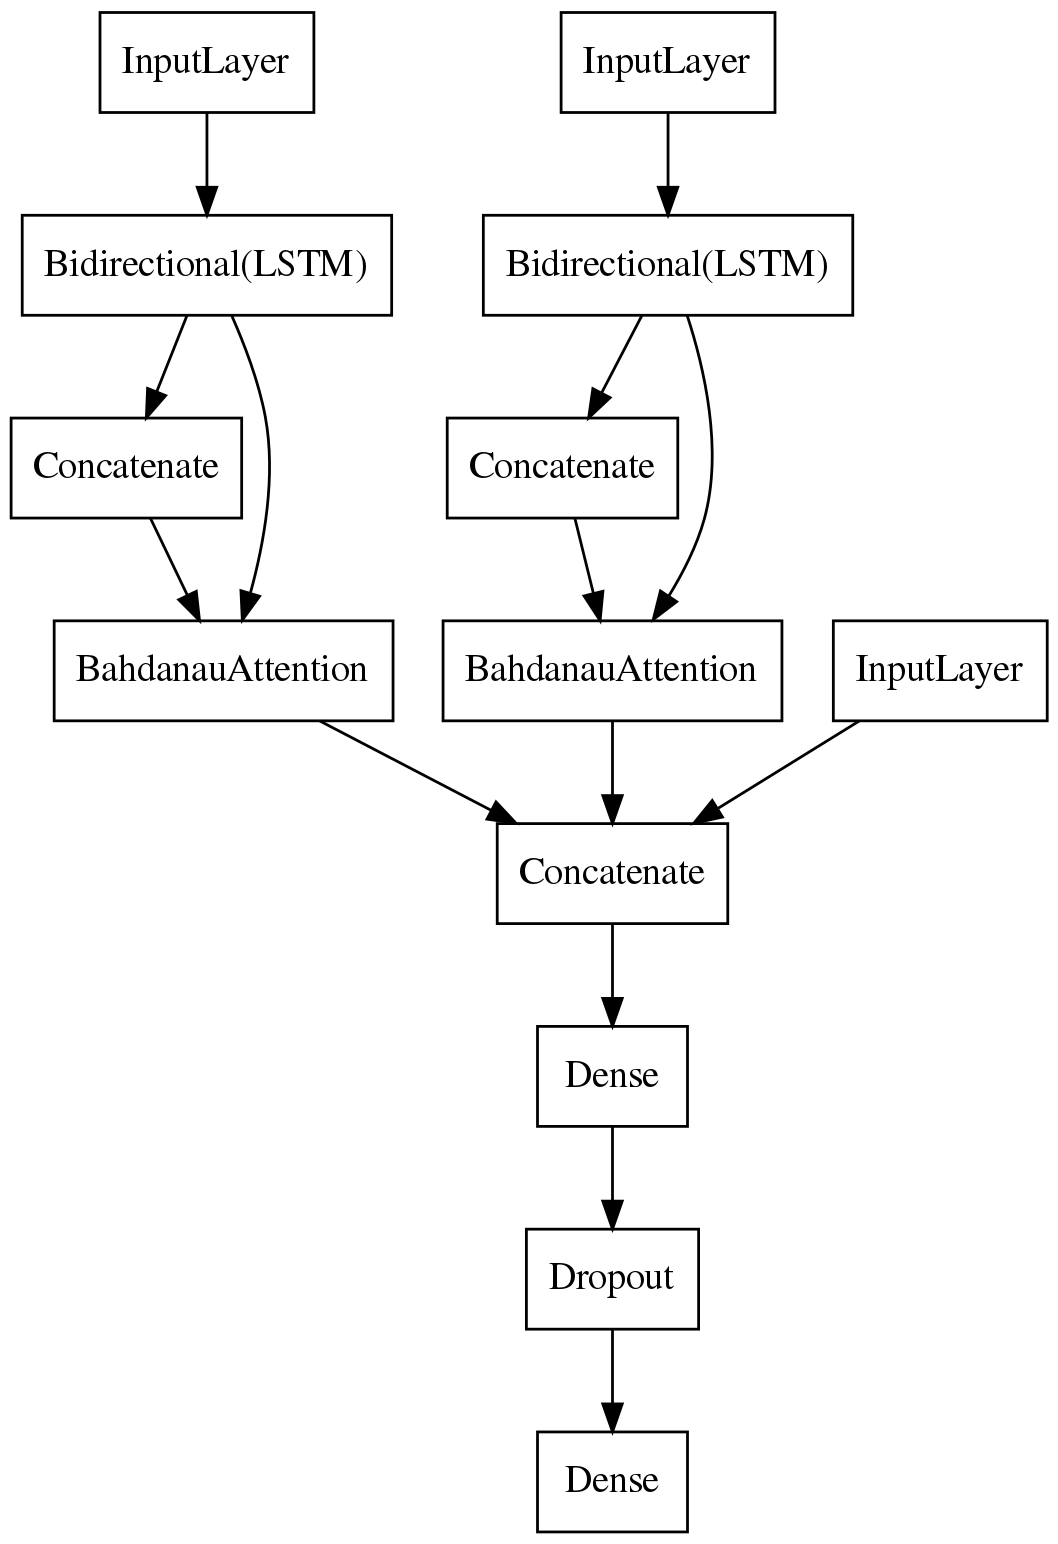

In [43]:
tf.keras.utils.plot_model(model, show_layer_names=False, dpi=200)

In [12]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(training_checkpoint_dir / 'weights-{epoch:03d}-{val_loss:.0f}.ckpt'),
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
)

In [13]:
hist = model.fit(
    x_train, y_train,
    batch_size=TRAIN_BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=VERBOSE,
    callbacks=[cp_callback]
)

Epoch 1/512
11/11 - 6s - loss: 1574941824.0000 - mae: 19521.4121 - mse: 1574941824.0000 - val_loss: 1506994560.0000 - val_mae: 19009.1738 - val_mse: 1506994560.0000
Epoch 2/512
11/11 - 5s - loss: 1570799872.0000 - mae: 19435.9590 - mse: 1570799872.0000 - val_loss: 1502843520.0000 - val_mae: 18926.9746 - val_mse: 1502843520.0000
Epoch 3/512
11/11 - 4s - loss: 1566328192.0000 - mae: 19353.1719 - mse: 1566328192.0000 - val_loss: 1498245632.0000 - val_mae: 18847.3730 - val_mse: 1498245632.0000
Epoch 4/512
11/11 - 4s - loss: 1561616512.0000 - mae: 19277.2363 - mse: 1561616512.0000 - val_loss: 1493605376.0000 - val_mae: 18777.0410 - val_mse: 1493605376.0000
Epoch 5/512
11/11 - 5s - loss: 1556723456.0000 - mae: 19208.0625 - mse: 1556723456.0000 - val_loss: 1488653184.0000 - val_mae: 18710.6426 - val_mse: 1488653184.0000
Epoch 6/512
11/11 - 5s - loss: 1551507584.0000 - mae: 19142.8320 - mse: 1551507584.0000 - val_loss: 1483332608.0000 - val_mae: 18648.6738 - val_mse: 1483332608.0000
Epoch 7/51

In [14]:
model.save(keras_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 5-training-model/lol/news-full-nouns-trigram-ft-pre200-title-contents-regression-211/assets


In [ ]:
tfa.register_all()
model = tf.keras.models.load_model(keras_model_path, custom_objects={'BahdanauAttention': BahdanauAttention})

### Scikit-learn

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
x_train_meta, x_val_meta, x_test_meta = my_train_val_test_split(np.concatenate([years, months, days, times, offices], axis=1))
regr = RandomForestRegressor(random_state=119).fit(x_train_meta, y_train)

y_pred_rf_train = regr.predict(x_train_meta)
y_pred_rf_val = regr.predict(x_val_meta)
y_pred_rf = regr.predict(x_test_meta)

for typ, true, pred in zip(['train', 'val', 'test'], [y_train, y_val, y_test], [y_pred_rf_train, y_pred_rf_val, y_pred_rf]):
    pred_plus = [-x if x < 0 else x for x in pred]
    print(typ)
    print(int(metrics.mean_squared_error(true, pred)))
#     print(np.sqrt(metrics.mean_squared_error(true, pred)))
#     print(np.sqrt(metrics.mean_squared_log_error(true, pred_plus)))
#     print(metrics.mean_absolute_error(true, pred))
    print(f'{metrics.r2_score(true, pred):.5}')
    print()

train
346832078
0.70954

val
1167541450
-0.018547

test
963575476
-0.35804



In [14]:
importances[indices]

array([0.33187656, 0.25473373, 0.16138697, 0.15039762, 0.10160512])

In [15]:
std[indices]

array([0.01119891, 0.01044401, 0.01045469, 0.01152008, 0.01125048])

In [17]:
indices

array([2, 3, 1, 4, 0])

(-1.0, 5.0)

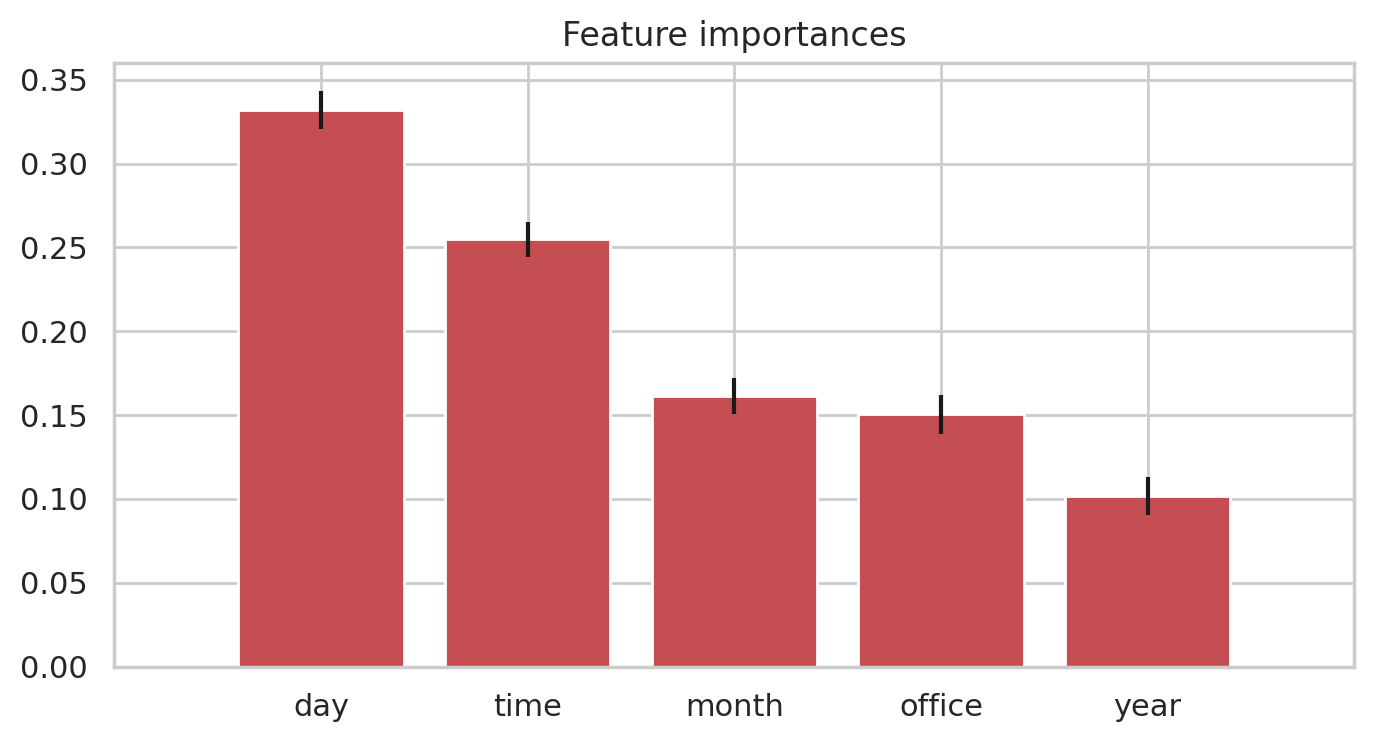

In [25]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.rcParams['figure.figsize'] = [8.0, 4.0]
plt.rcParams['figure.dpi'] = 200
plt.title('Feature importances')
plt.bar(['day', 'time', 'month', 'office', 'year'], importances[indices],
        color="r", yerr=std[indices], align='center')
#plt.xticks(range(x_train_meta.shape[1]), indices)
plt.xlim([-1, x_train_meta.shape[1]])

### attention

In [23]:
# plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic')

In [24]:
model.layers

In [24]:
layer_inp_title    = model.layers[0]
layer_att_title    = model.layers[6]
fn_title = K.function([layer_inp_title.input], [layer_att_title.output])

layer_inp_contents = model.layers[1]
layer_att_contents = model.layers[7]
fn_contents = K.function([layer_inp_contents.input], [layer_att_contents.output])

layer_dense_text  = model.layers[9]
fn_text = K.function([layer_inp_title.input, layer_inp_contents.input], [layer_dense_text.output])

In [25]:
index = (df_train.date == 20190708) & (df_train.ranking == 1)
print('true:', y_train[index][0])
print('pred:', model.predict([x_train[0][index], x_train[1][index]], batch_size=1)[0][0])

true: 113091
pred: 38541.35


In [26]:
title_words = [join_jamos(x) for x in df_train.title[index].to_list()[0].split(' ')[:16]]
contents_words = [join_jamos(x) for x in df_train.contents[index].to_list()[0].split(' ')[:128]]
title = ' '.join(title_words)
contents = ' '.join(contents_words)
print(title)
print(contents)

현장 메모 분 조출 김정균_감독 페이커 이상혁 우승
텔레콤 프로_게임_단 김정균_감독 팀 핵심_멤버 페이커 이상혁 리프트_라이벌_즈 우승 확정 뒤 인터뷰 도착 관심


<BarContainer object of 8 artists>

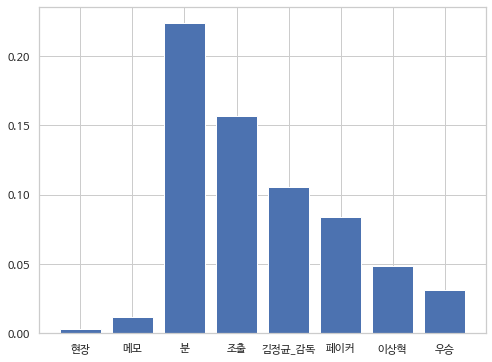

In [27]:
att_w_vec = fn_title(x_train_title[index])[0][1][0].reshape(16)

att_w_vec_reverse = 1 / att_w_vec[:len(title_words)]
att_w_vec_reverse /= sum(att_w_vec_reverse)

plt.rcParams['figure.figsize'] = [8, 6]
plt.bar(title_words, att_w_vec[:len(title_words)])

<BarContainer object of 14 artists>

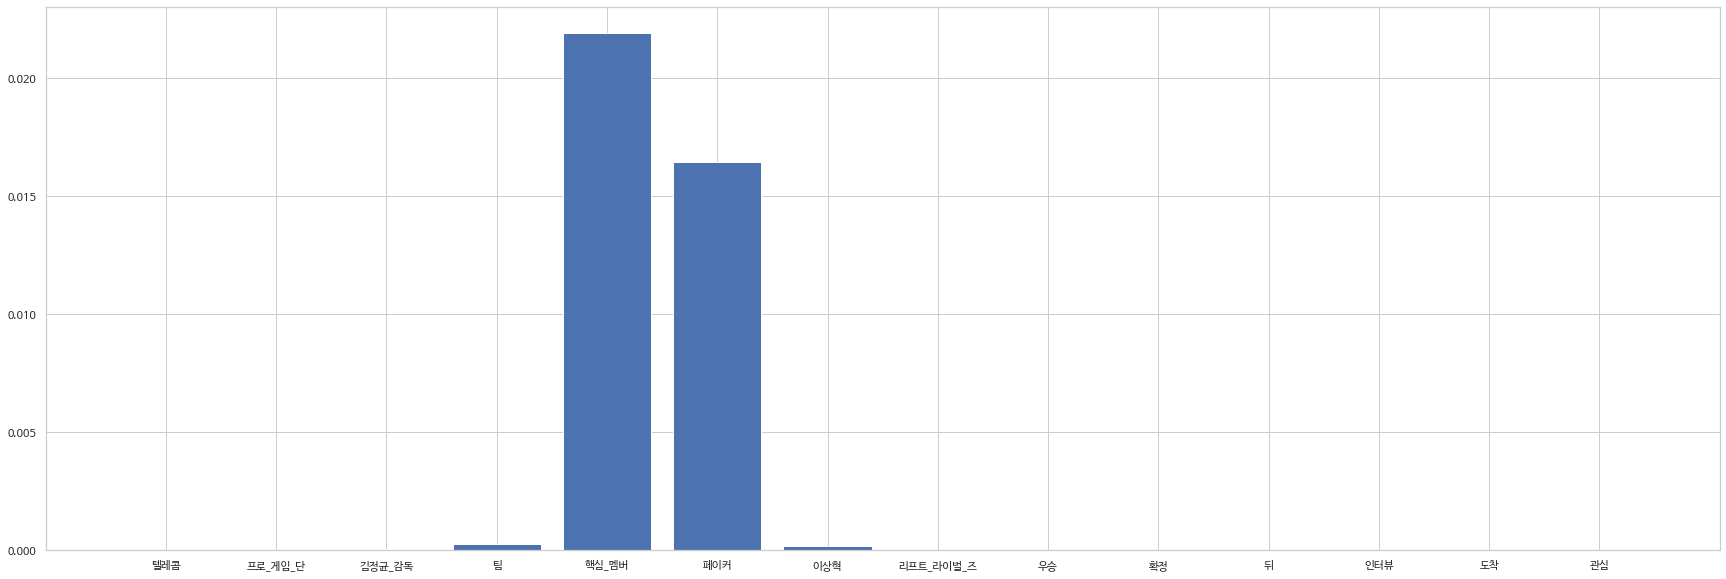

In [31]:
att_w_vec_contents = fn_contents(x_train_contents[index])[0][1][0].reshape(128)
plt.rcParams['figure.figsize'] = [30.0, 10.0]
plt.bar(contents_words, att_w_vec_contents[:len(contents_words)])

In [54]:
print('\n'.join(title_words))
print()
print('\n'.join(map(str, att_w_vec[:len(title_words)])))

현장
메모
분
조출
김정균_감독
페이커
이상혁
우승

0.0010176625
0.0043863077
0.0049572815
0.050347455
0.2602976
0.08265313
0.15931807
0.028586393


In [31]:
print('\n'.join(contents_words))
print()
print('\n'.join(map(str, att_w_vec_contents[:len(contents_words)])))

한국
리프트_라이벌
결승전
중국
상대
리그
출범
후
우승
차지
대표
팀
일_서울_장충
체육관
리그_오브_레전드
리프트_라이벌
이하
리프트_라이벌_즈
결승전
인_빅_터스_게이밍
톱
스포츠
펀_플럭스_피닉스
게
밍
상대
대
승리
선봉장
킹_존
드래곤
조별_풀_리그
유일
승
텔레콤
인_빅_터스_게이밍
상대
초반
주도
데프_트
김혁규
활약
전투
승리
기분
출발
기세
텔레콤
톱
스포츠
상대
페이커
이상혁
니코
만
개
규모_전투
빛
유리
전투
구도
마타
조세
노틸러스
닻줄
적
발
승리
차지
세트
출전
그리핀
펀_플러스_피닉스
경기
김태상
판테온
기습
수차례
킬
허용
차례
전투
손해
만회
격차
게
밍
상대
세트
담원_게이밍
초반
베_이드
전략
선취점
킬
허용
협곡
전령
앞
규모_전투
베릴_조건희
알리스타
적
후방
완벽
역전
발판
전투
승리
기세
담원
사방
적
차례
승리
쐐기
대
승리
리프트_라이벌
출범
이후
처음
결승전
상대
승리
우승
차지

3.152039e-07
3.6165056e-07
1.0308206e-06
3.6083497e-06
1.7586094e-06
1.8560027e-06
1.3256463e-06
1.8441602e-06
1.2397836e-06
3.9481943e-06
5.106752e-06
1.3320594e-05
4.612721e-06
2.5790073e-06
1.8218827e-06
8.206639e-07
5.125074e-07
6.713155e-07
1.1668612e-06
1.2772858e-06
6.716281e-07
1.5256408e-06
1.3155909e-06
1.3088583e-06
7.4701205e-07
1.2413927e-06
6.2137957e-07
1.1236375e-06
8.772823e-07
1.056176e-06
2.274447e-06
8.5879924e-07
2.145507e-06
1.4968745e-06
1.6471963e-06
7.5204713e-07
1.3263392e-06
1.5765336e-06
7.571190

### evaluate

In [17]:
model.load_weights(str(training_checkpoint_dir / 'weights-343-934443072.ckpt'))

In [18]:
y_pred_train = model.predict(x_train, batch_size=TEST_BATCH_SIZE, verbose=0).reshape(y_train.shape)
y_pred_val = model.predict(x_val, batch_size=TEST_BATCH_SIZE, verbose=0).reshape(y_val.shape)
y_pred = model.predict(x_test, batch_size=TEST_BATCH_SIZE, verbose=0).reshape(y_test.shape)

In [19]:
for typ, true, pred in zip(['train', 'val', 'test'], [y_train, y_val, y_test], [y_pred_train, y_pred_val, y_pred]):
    pred_plus = [-x if x < 0 else x for x in pred]
    print(typ)
    print(metrics.mean_squared_error(true, pred))
    print(int(np.sqrt(metrics.mean_squared_error(true, pred))))
    print(np.sqrt(metrics.mean_squared_log_error(true, pred_plus)))
    print(int(metrics.mean_absolute_error(true, pred)))
    print(metrics.r2_score(true, pred))
    print()

train
809769035.3237594
28456
3.2733571933657823
17275
0.3218465958926443

val
934443014.453002
30568
3.3212199435281193
18359
0.1848049408652629

test
690513857.5141476
26277
1.6461640000381332
16242
0.0268057484664036



In [23]:
beg_unts = [
[20200100, 20200200],
[20200200, 20200300],
[20200300, 20200400],
[20200400, 20200500]]

r2s = []
mses = []
for beg, unt in beg_unts:
    test_sample_range = df_test.date.apply(lambda x: beg < x < unt)
    y_test_sample = y_test[test_sample_range]
    y_pred_sample = y_pred[test_sample_range]
    r2s.append(metrics.r2_score(y_test_sample, y_pred_sample))
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(y_test_sample, y_pred_sample)
    mses.append(m.result().numpy())

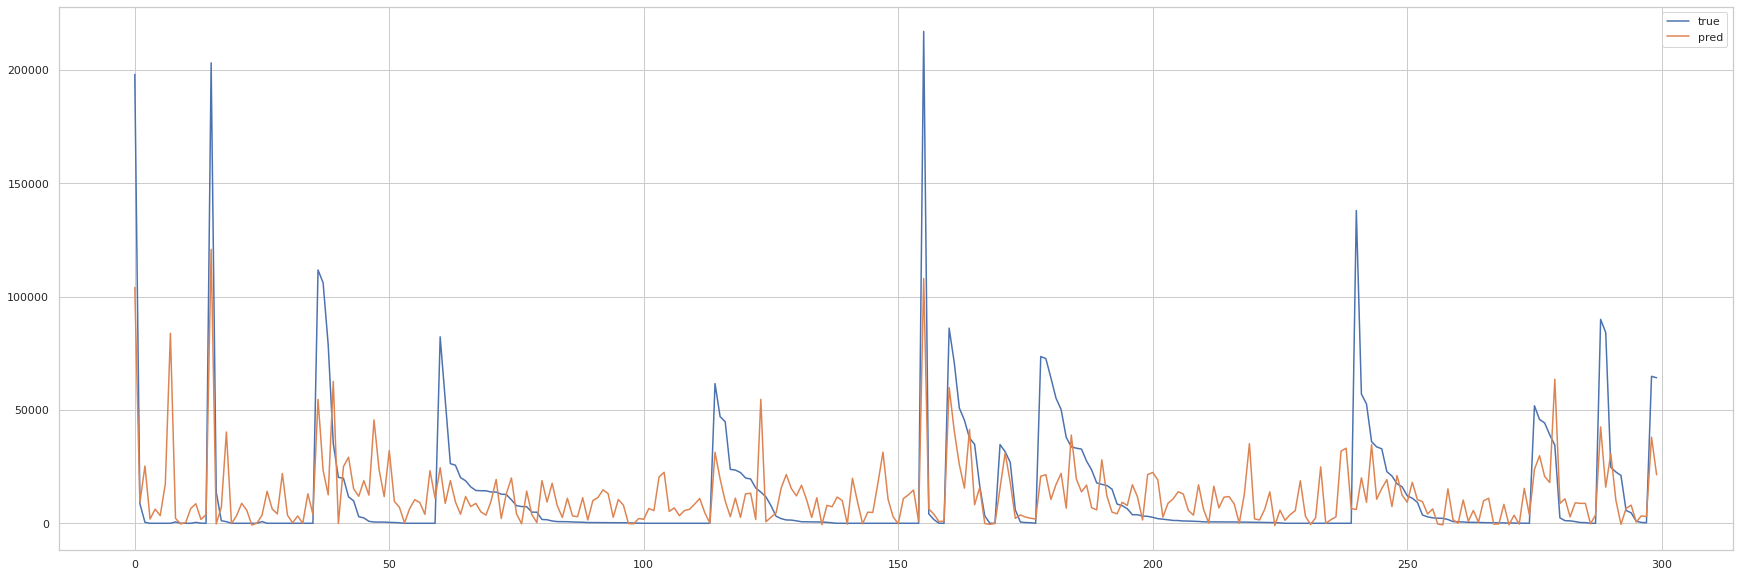

In [19]:
plt.rcParams['figure.figsize'] = [30.0, 10.0]
plt.plot(y_train[:300], label='true')
plt.plot(y_pred_train[:300], label='pred')
plt.legend()

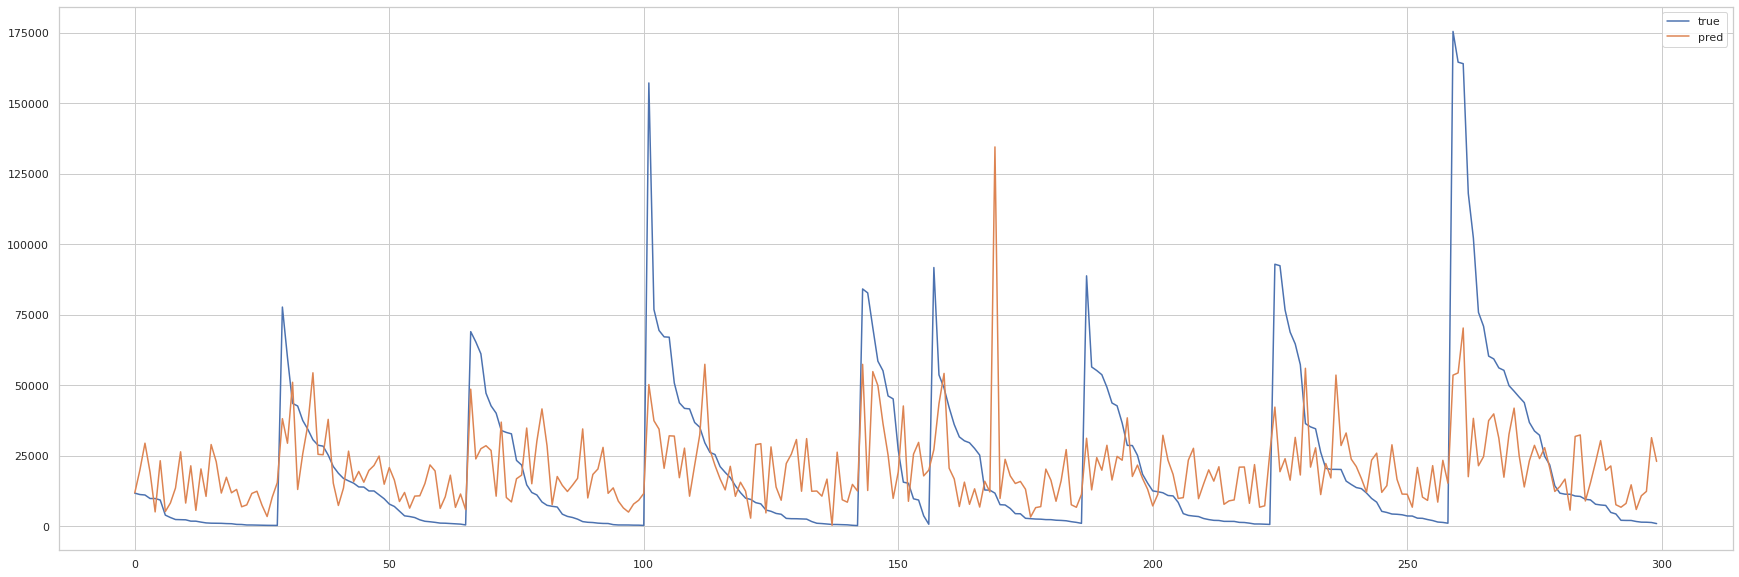

In [20]:
plt.rcParams['figure.figsize'] = [30.0, 10.0]
plt.plot(y_train[-300:], label='true')
plt.plot(y_pred_train[-300:], label='pred')
plt.legend()

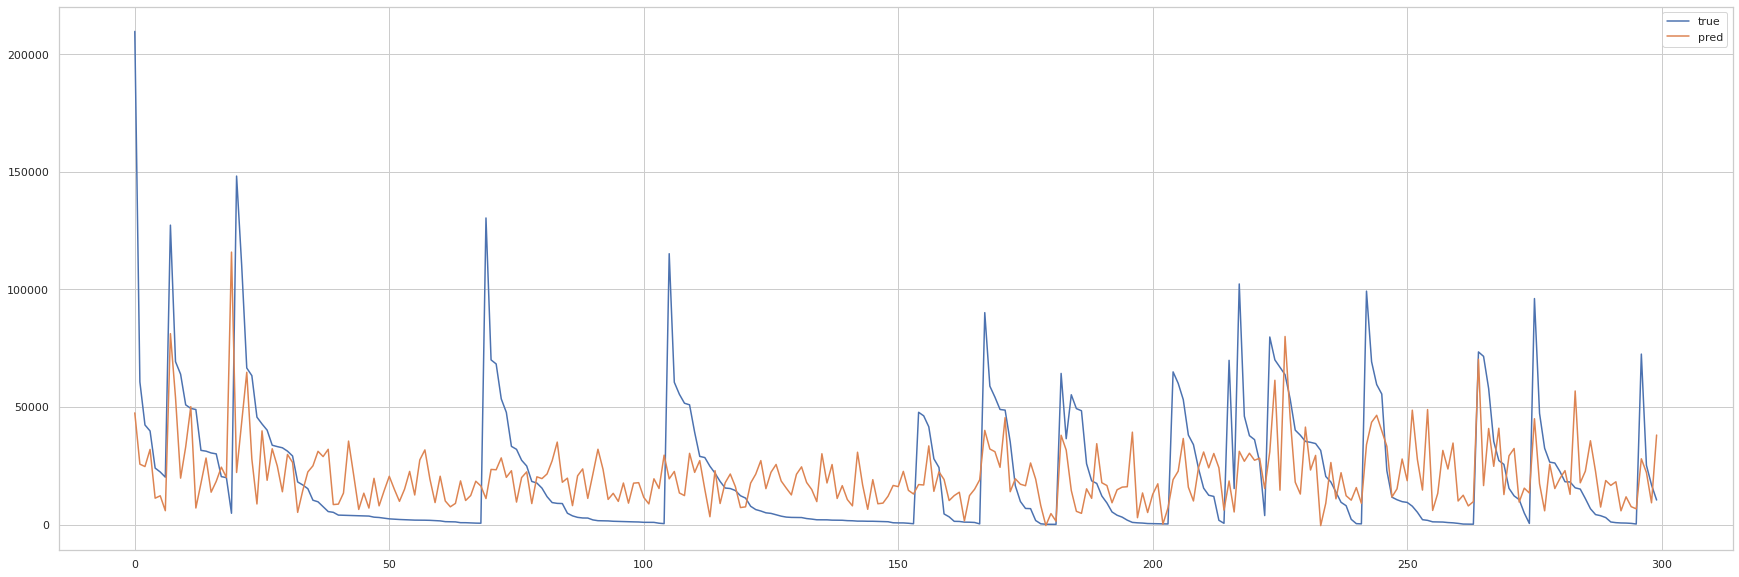

In [21]:
plt.rcParams['figure.figsize'] = [30.0, 10.0]
plt.plot(y_test[:300], label='true')
plt.plot(y_pred[:300], label='pred')
plt.legend()

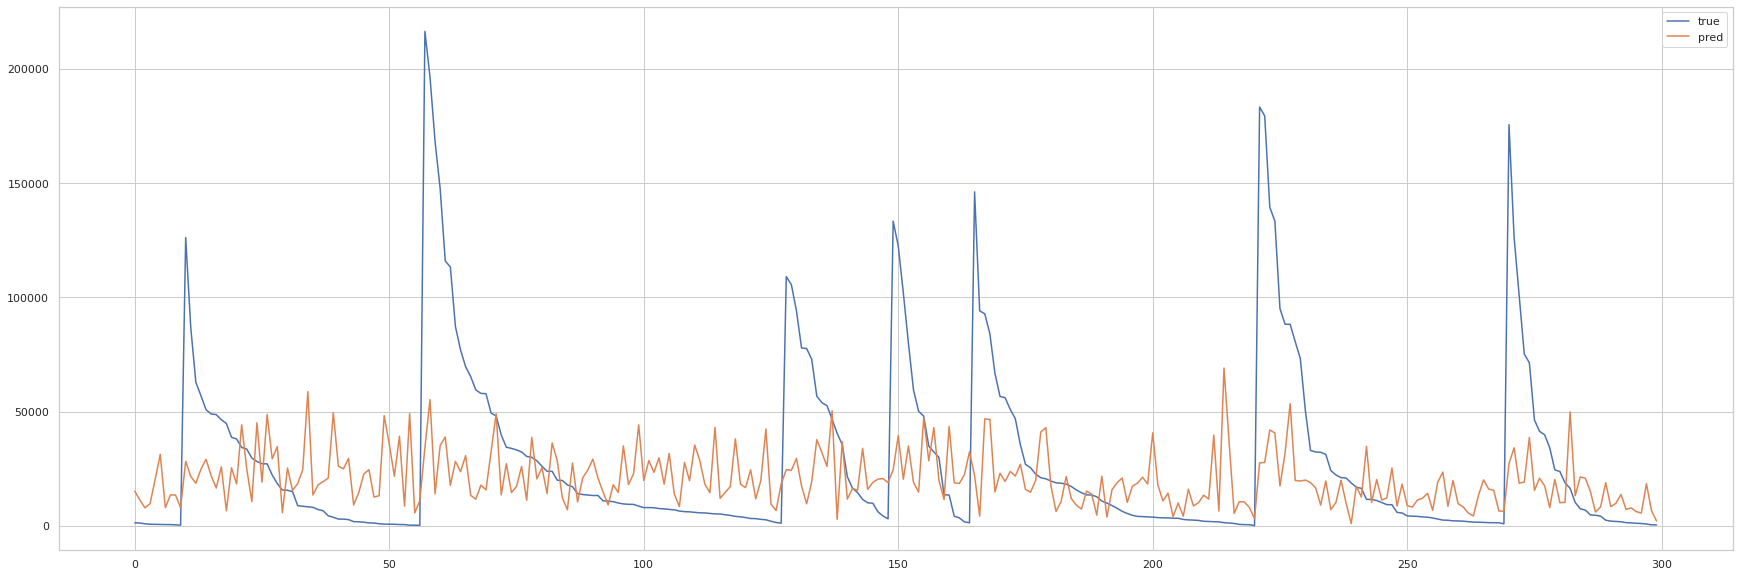

In [22]:
plt.rcParams['figure.figsize'] = [30.0, 10.0]
plt.plot(y_test[-300:], label='true')
plt.plot(y_pred[-300:], label='pred')
plt.legend()

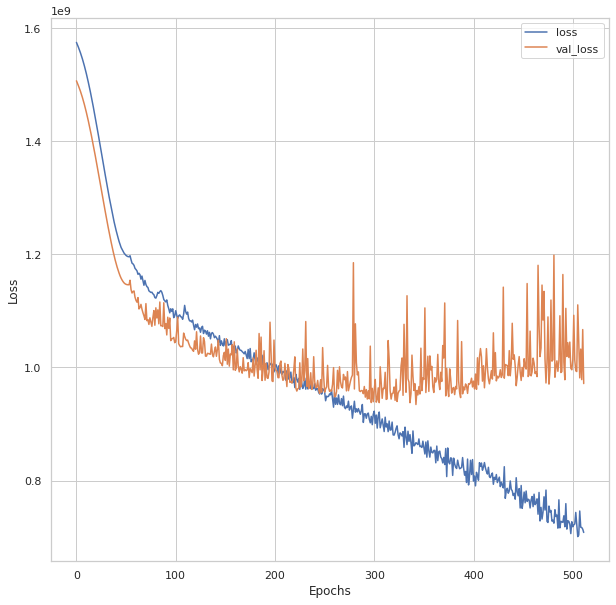

In [15]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

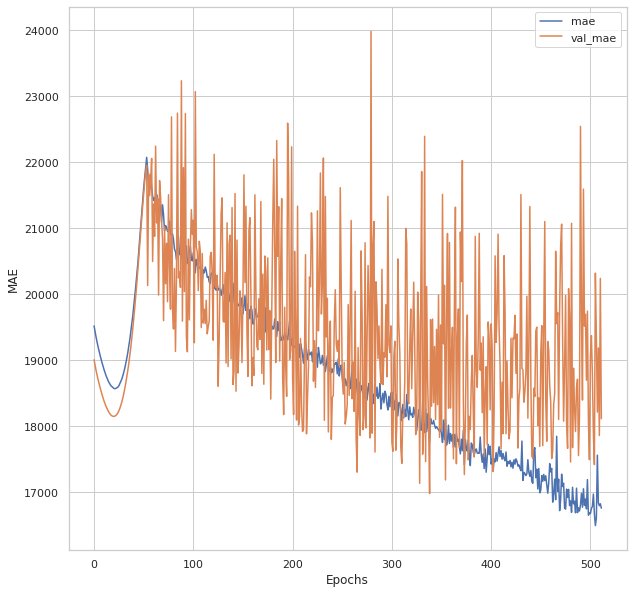

In [16]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(hist.history['mae'], label='mae')
plt.plot(hist.history['val_mae'], label='val_mae')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()
plt.show()